## This notebook loads each of the benchmarked models (DeepSEA/DanQ/DeepAtt) one by one and then generates predictions using each model. 

- Using this notebook, one can evaluate the performance on both the random test data and the native test data for each benchmarked model


#### Important Note : 
- Our test datasets in the manuscript are not simply held-out subsets of the training datasets. They are separate test datasets generated as part of completely independent experiments with lower-complexity (~1000 fold lower sequence diversity) libraries than the large-scale training data generation experiments resulting in expression measurements with a low measurement-error. The test data used here can be found in the `../../../data/test_data/` folder relative to this notebook's current directory.
- Since the training data and the test data are collected in different experiments, the units of expression are on different unrelated scales (the units are arbitrary units local to experiments and not absolute comparable units across experiments) because of the nature of GPRA/Sort-seq experiments.


### Imports

In [1]:
import sys
sys.path.insert(0, './')



import BioinforDeepATT
from BioinforDeepATT.model.model import *

from rr_aux import *

import sys
sys.path.insert(0, './')
#%load_ext autoreload
#%autoreload 2
from rr_aux import *


##Clear Memory 
#tf.reset_default_graph()
tf.keras.backend.clear_session()
gc.collect()
##

/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/edv/anaconda3/envs/evolution/lib/python3

0

### Load the models DeepSEA / DeepAtt / DanQ

#### Pick the benchmarking model you would like to use from :
- `'DanQ_model'`
- `'DeepSEA_model'`
- `'DeepAtt_model'`

In [24]:
model_name = 'DanQ_model'#'DanQ_model' , 'DeepSEA_model' , 'DeepAtt_model'

#### Load the chosen benchmarking model ( DeepSEA / DeepAtt / DanQ )
The saved model is available in this directory under the name `[model_name].h5`


##### Note about the final layer :

We emphasize that the final layer does have a <b>single output unit and a linear activation</b> as one would expect. This is can be verified by looking at the following line in the `benchmarking.py` file in this folder and also in the cell below : <br>
<code>output_layer = Dense(1, kernel_regularizer = l1_l2(l1=l1_weight, l2=l2_weight),
                     activation='linear', kernel_initializer='he_normal', use_bias=True )(x) 
</code>


#####  Note about the DeepAtt() model : 

- The reader will notice that there is a fitness_function_model() call instead of DeepAtt() for the model_name = 'DeepAtt'. The reason is that there are some non JSON-serializable layers in the DeepAtt() function invocation (from their original authors) which makes it difficult to save using model.save(). The model can be trained (using notebook 2 in this folder) but the jupyter notebook needs to be kept running for the complete analysis (including computing predictions and computing ECC using this model) since model.save_weights() results in errors when loading and model.save() will not work. 
- The ECC for DeepAtt was also similarly calculated using this single running notebook from end to end using the DeepAtt() call to stay faithful to the original implementation. We also save a model trained using our own implementation of the DeepAtt() model with JSON-seriable layers for future predictions.
- So, to save a version of the 'DeepAtt' model, we use our own layers to address the issues we had in saving with the implementation in DeepAtt() from the original authors. 
- It can be verified that both lead to equivalent performance by changing the 'define_DeepAtt_here' flag in Notebook 2 and the bechmarking.py file.
- The DeepAtt() model was trained from scratch here again (in this same VM and environment) using both approaches (our adapted approach and the original authors approach) to verify the equivalent peformance and it worked as expected consistently.


In [25]:

if model_name in ['DanQ_model' , 'DeepSEA_model']:
    model = tf.keras.models.load_model(model_name+'.h5')
    
else :
    

    def fitness_function_model(model_params) :

        batch_size= model_params['batch_size']
        l1_weight= model_params['l1_weight']
        l2_weight= model_params['l2_weight']
        lr= model_params['lr']
        device_type = model_params['device_type']
        input_shape = model_params['input_shape']
        loss = model_params['loss']
        model_name = model_params['model_name']

        if(model_params['device_type']=='tpu'):
            input_layer = Input(batch_shape=(batch_size,input_shape[1],input_shape[2]))  #trX.shape[1:] #batch_shape=(batch_size,110,4)

        else :
            input_layer = Input(shape = input_shape[1:] , batch_size = 1024)  #trX.shape[1:] #

        if model_name=='DeepAtt':
            if 1 : 
                x = Conv1D(256, 30, padding='valid' ,\
                       kernel_regularizer  = l1_l2(l1=l1_weight, l2=l2_weight), kernel_initializer='he_normal' ,
                      data_format = 'channels_last' , activation='relu')(input_layer) 
                x = tf.keras.layers.MaxPool1D( pool_size=3, strides=3, padding='valid')(x)
                x= tf.keras.layers.Dropout(0.2)(x)
                x = Bidirectional(LSTM(16, return_sequences=True,kernel_initializer='he_normal'))(x)
                x = MultiHeadAttention( head_num=16)(x) 
                x = tf.keras.layers.Dropout(0.2)(x)
                x = Flatten()(x)

                x = keras.layers.Dense(
                        units=16,
                        activation='relu')(x)
                x = keras.layers.Dense(
                    units=16,
                    activation='relu')(x)
            else : 
                x = DeepAtt()
                x = x.call(input_layer)

        if model_name=='DanQ':
            x = DanQ()
            x = x.call(input_layer)

        if model_name=='DeepSEA':
            x = DeepSEA()
            x = x.call(input_layer)

        if(len(x.get_shape())>2):
            x = Flatten()(x) 

        ### Note to Reviewer 3 : this layer was appended to each to each model above
        output_layer = Dense(1, kernel_regularizer = l1_l2(l1=l1_weight, l2=l2_weight),
                        activation='linear', kernel_initializer='he_normal', use_bias=True )(x) 


        model = Model(input_layer, output_layer)
        opt = tf.compat.v1.train.AdamOptimizer(lr) #tf.keras.optimizers.Adam(lr=lr)#


        model.compile(optimizer=opt, loss=loss,metrics=['mean_squared_error', 'cosine_similarity']) 

        return model

    model_params = {
            'n_val_epoch' : 1000,
            'epochs' : 3, #3 used previously
            'batch_size': int(1024*1), # int(1024*3) , #64*55 fits , #best batch size is 1024
            'l1_weight': 0,#1e-6#1e-7#0.01 # l1 should always be zero
            'l2_weight': 0,#1e-7#0.01
            'lr':0.001,
            'device_type' : 'gpu', #'tpu'/'gpu'/'cpu'
            'input_shape' : (30722048, 110, 4),
            'loss' : 'mean_squared_error', 
            'model_name' : 'DeepAtt'}

    model=fitness_function_model(model_params)
    model.load_weights('DeepAtt_model.h5')
    
scaler= sklearn.externals.joblib.load(os.path.join('..','..','..','data','Glu','scaler.save'))
batch_size = 1024

/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.3 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Random Test Data

### Load random test data

#####  ‘Random Test Data’ definition: 
The test data corresponding to Figure 1a. This test dataset is a a fresh random sample of sequences from the complete sequence space whose expression in the complex medium is measured separately of the training data generation experiment allowing for high quality expression measurements. 


##### Notes : 
- The next cell shows how to load the random test data (also referred to by us as the HQ test data, this was generated from a completely independent experiment than the one used for generating the training data). We elaborate on this extensively in the Reviewer response.

- It has also been available on Zenodo at https://zenodo.org/record/4436477/files/Random_testdata_complex_media.txt?download=1 and can be accessed from `../../../data/test_data/HQ_testdata.txt` relative to the current directory as well.

In [26]:

def read_hq_testdata(filename) :
    #### Convert sequence to one hot code and return sequence, expression pairs
    with open(filename) as f:
        reader = csv.reader(f, delimiter="\t")
        d = list(reader)

    sequences = [di[0] for di in d]

    
    for i in tqdm(range(0,len(sequences))) : 
        if (len(sequences[i]) > 110) :
            sequences[i] = sequences[i][-110:]
        if (len(sequences[i]) < 110) : 
            while (len(sequences[i]) < 110) :
                sequences[i] = 'N'+sequences[i]


    #One hot code
    A_onehot = np.array([1,0,0,0] ,  dtype=np.bool)
    C_onehot = np.array([0,1,0,0] ,  dtype=np.bool)
    G_onehot = np.array([0,0,1,0] ,  dtype=np.bool)
    T_onehot = np.array([0,0,0,1] ,  dtype=np.bool)
    N_onehot = np.array([0,0,0,0] ,  dtype=np.bool)

    mapper = {'A':A_onehot,'C':C_onehot,'G':G_onehot,'T':T_onehot,'N':N_onehot}
    worddim = len(mapper['A'])
    seqdata = np.asarray(sequences)
    seqdata_transformed = seq2feature(seqdata)
    print(seqdata_transformed.shape)


    expressions = [di[1] for di in d]
    expdata = np.asarray(expressions)
    expdata = expdata.astype('float')  

    return np.squeeze(np.asarray(sequences)),np.squeeze(seqdata_transformed),expdata

sequences,X,Y = read_hq_testdata(os.path.join(os.path.join('../../../data/test_data/HQ_testdata.txt')))
Y = [float(x) for x in Y]


100%|██████████| 3331/3331 [00:00<00:00, 1574045.36it/s]
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/evolution/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/edv/anaconda3/envs/ev

(3331, 110, 4)


#### Use the loaded DeepSEA / DeepAtt / DanQ model to predict expression

In [27]:
Y_pred= evaluate_model(X, model, scaler)

pcc = scipy.stats.pearsonr(Y,Y_pred )[0]
print(f'The Pearson\'s r for the random test data is', format(pcc, '0.3f'))



4096/4096 [==============================] - 1s 265us/sample
The Pearson's r for the random test data is 0.963


#### Plot the scatterplot to visualize the prediction performance

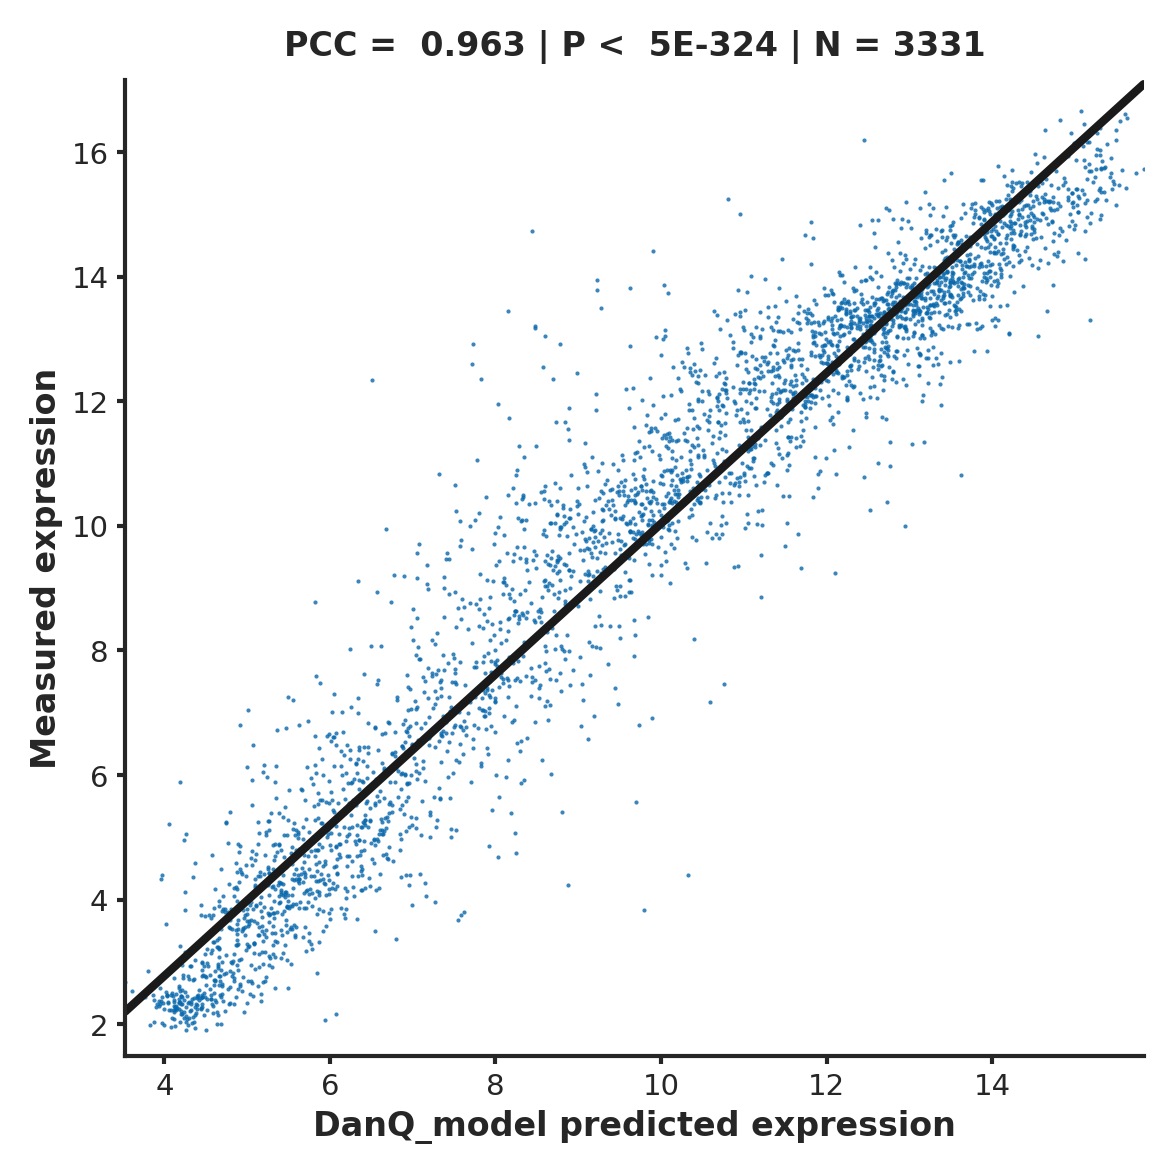

In [28]:
fig_file = model_name+" prediction_performance"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = list(Y_pred)
y = Y

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [29]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : Y,
              'Predicted Expression' : Y_pred})
results_df.to_csv('../../../results_summary/Random_test_'+model_name+'.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,NNNNNNNNNNTGCATTTTTTTCACAAGAGCACTTGAAGGGCGCCTA...,13.708592,13.119652
1,NNNTGCATTTTTTTCACACATATACTTGGGTGACTTAGATATTTGC...,2.553335,4.414244
2,NTGCATTTTTTTCACACATCTGGATTGTCTGGTGTGCTGGTATCTT...,13.369969,12.103359
3,NTGCATTTTTTTCACACCACCGTGGGGATTCGCAGCTATGTGCATA...,3.328683,5.189512
4,NNTGCATTTTTTTCACACCATGGATTTAAGAATTAATCACCGGACA...,10.466688,10.208051
...,...,...,...
3326,NNTGCATTTTTTTCACTCTTTCACGTGGGGCCTGCGGGGTATCGGT...,14.962475,14.365745
3327,NNNNNNNNNNNNTGCATTTTTTTCACTGATGTGGTGCGCGTAATTT...,11.999880,13.150097
3328,TGCATTTTTTTCACTTCCAGTAATATGCGAAAGGGTGATGTGAACT...,4.541188,6.073486
3329,NNNNNNNNNNNNNNTGCATTTTTTTCACTTCGCACTCCACTTCTCG...,7.456650,10.761127


# Native Test Data

### Load native test data 

#####  ‘Native Test Data’ definition: 
This test dataset corresponds to a set of native yeast promoter sequences from the S288C reference genomes. As above, they are measured in an experiment separate from the large training data generation experiment. 



In [30]:
native_df = pd.read_csv('../../../data/test_data/Native_testdata.csv', index_col = 0 )

In [31]:
sequences = list(native_df.seq110.values)
expressions = list(native_df.meanEL.values)

#### Use the loaded DeepSEA / DeepAtt / DanQ model to predict expression

In [32]:
predicted_expressions= evaluate_model(sequences, model, scaler)

pcc = scipy.stats.pearsonr(expressions,predicted_expressions )[0]
print(f'The Pearson\'s r for the native test data is', format(pcc, '0.3f'))



4096/4096 [==============================] - 1s 183us/sample
The Pearson's r for the native test data is 0.916


#### Plot the scatterplot to visualize the prediction performance

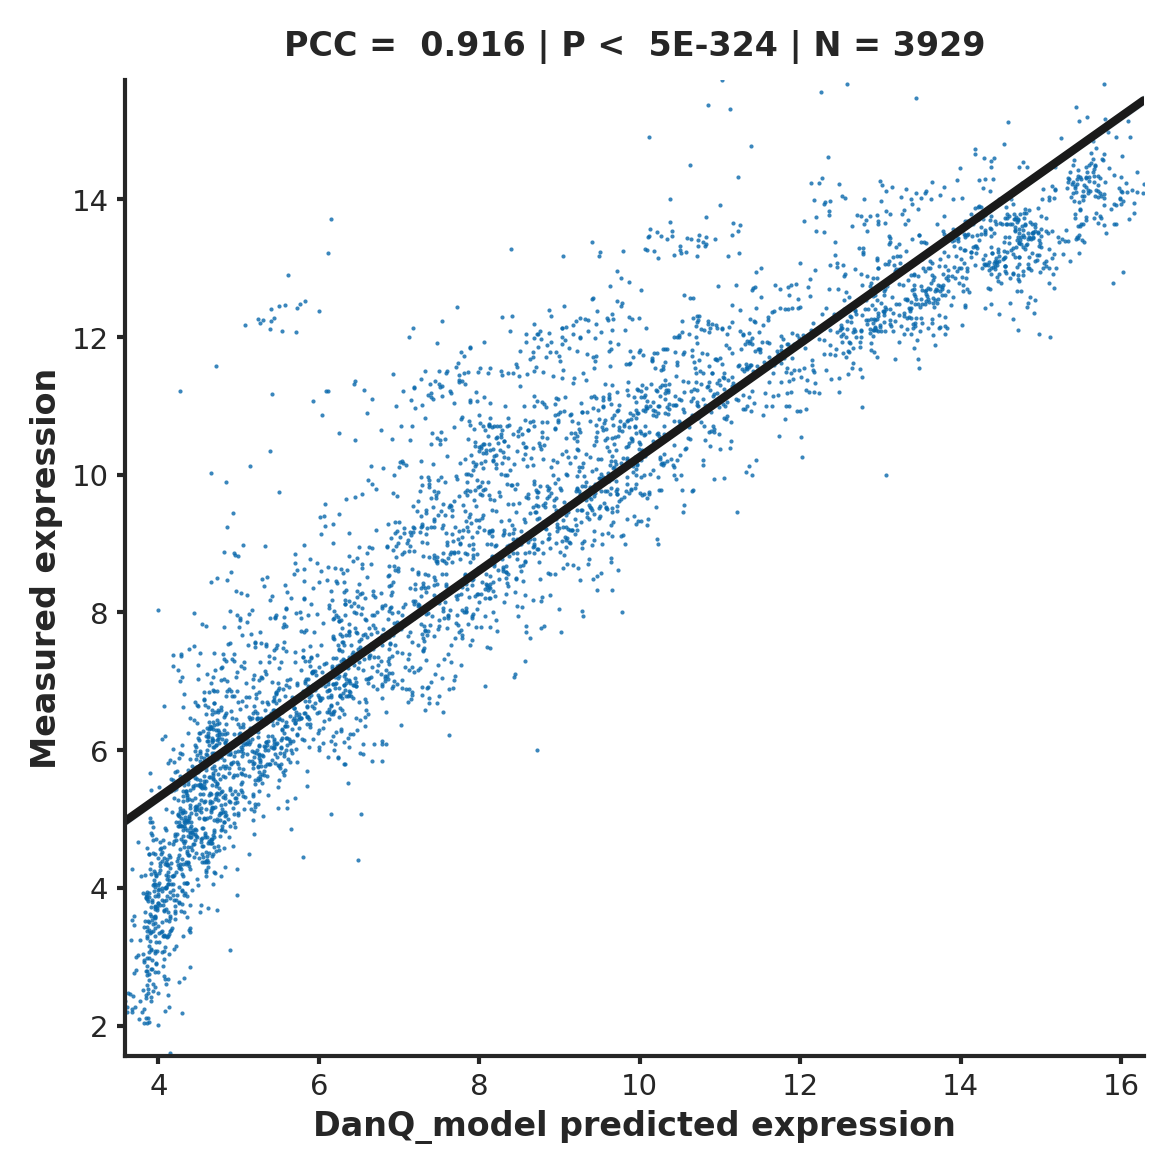

In [33]:
fig_file = model_name+" prediction_performance_native"

fig=plt.figure(figsize=(4,4) , dpi= 300, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)



x = predicted_expressions
y = expressions

r = scipy.stats.pearsonr(x ,y )
sns.regplot(x=x ,y=y ,
            scatter_kws= {'s':1,'linewidth':0, 'rasterized':True} ,
            line_kws= {'linewidth':2} ,
            color= '#0868ac', robust = 1 )



ax = plt.gca()
#ax.get_legend().remove()


ax.set_xlabel(model_name + " predicted expression")
ax.set_ylabel("Measured expression")
if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )


plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-8,xmax=8)
#ax.set_ylim(ymin=-8,ymax=8)



plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")

plt.show()

### Save the results to a file for convenient generation of summary plots

In [34]:
results_df = pd.DataFrame({'sequence': sequences , 
              'Measured Expression' : expressions,
              'Predicted Expression' : predicted_expressions})
results_df.to_csv('../../../results_summary/Native_test_'+model_name+'.csv')
results_df

,sequence,Measured Expression,Predicted Expression
0,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAACAAAGAAAAAGG...,13.168816,14.733044
1,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAACAAAAAGG...,13.457919,14.753833
2,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAAGAAAAAGA...,13.855758,14.806000
3,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAAGAAAAAGG...,12.043120,13.382413
4,TGCATTTTTTTCACATCAAAAAAAAAAAGAAAAAGAAAGAAAAAGG...,13.529583,14.964939
...,...,...,...
3924,TGCATTTTTTTCACATCTTTTTTGATGCGCTATCATCCATTATTCT...,7.344921,5.901438
3925,TGCATTTTTTTCACATCTTTTTTGATGCGCTATCATCCATTATTCT...,6.589246,5.329819
3926,TGCATTTTTTTCACATCTTTTTTGATGCGCTATCATCCATTATTCT...,7.740563,5.835606
3927,TGCATTTTTTTCACATCTTTTTTGATGCGCTATCATCCCTTATTCT...,7.421802,5.706168
